In [1]:
import sys
sys.path.append('../src')
from utils import ExportResults, Visualization

exp_res = ExportResults()
viz = Visualization()

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='dse-staff')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


In [ ]:
# Combine results
df = exp_res.combine_gcs_csvs(bucket_name='dse-staff',folder_path='protected_areas/tables')

# Calculate columns
df['boundary_edge'] = df['boundary_x_mean'] / df['boundary_x_count']
df['buffer_edge'] = df['buffer_x_mean'] / df['buffer_x_count'] 
df['edge_ratio'] = df['boundary_edge'] / df['buffer_edge']

# Reformat columns for plot
df['WDPA_PID'] = df['WDPA_PID'].astype(str)
df['year'] = df['year'].astype(str)

/usr/local/lib/python3.10/dist-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


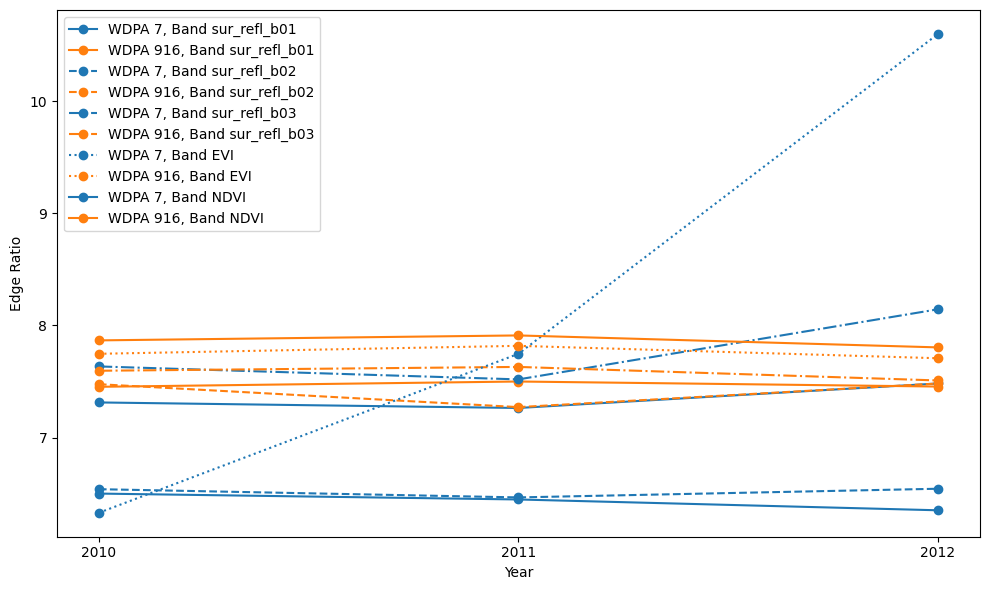

In [4]:
viz.plot_edge_ratio(df)